In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
from sklearn.feature_extraction.text import CountVectorizer
import sys
import gower
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas.api.types import CategoricalDtype
from itertools import islice
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph
import scipy.stats as stats


Reading the csv-file

In [2]:
df = pd.read_csv(r"C:\Users\Max_G\OneDrive\IUBH\3. Semester\Machine Learning Unsupervised\mental-heath-in-tech-2016_20161114.csv")


Saving original columns

In [3]:
df_original_columns = df.columns

Renaming columns. Credits to: 

In [4]:
renamed_columns = ['self_employed', 'number_of_employees', 'company_in_tech', 'role_in_tech', 'company_mental_health',
                  'company_mental_health_options_awareness', 'company_mental_health_discussion', 'company_mental_health_resources', 
                   'company_mental_health_anonymity','company_mental_health_leave', 'company_mental_health_discussion_impact', 
                   'company_physical_health_discussion_negative_impact', 'mental_health_coworkers_discussion',
                   'mental_health_supervisor_discussion', 'company_mental_health_serious', 
                   'company_mental_health_coworker_discussion_negative_impact', 'mental_health_coverage', 'mental_health_online_resources',
                  'mental_health_diagnosed_reveal', 'mental_health_diagnosed_reveal_impact', 'mental_health_diagnosed_coworker_reveal', 
                   'mental_health_diagnosed_coworker_reveal_impact_negative','mental_health_productivity_impact', 
                   'mental_health_productivity_impact_percent', 'previous_companies', 'previous_companies_mental_health_benefits', 
                   'previous_companies_mental_health_benefits_awareness','previous_companies_mental_health_discussion', 
                   'previous_companies_mental_health_resources', 'previous_companies_mental_health_anonymity', 
                   'previous_companies_mental_health_discussion_negative_impact', 
                   'previous_companies_physical_health_discussion_negative_impact',
                  'previous_companies_mental_coworkers_health_discussion', 'previous_companies_mental_supervisor_health_discussion', 
                   'previous_company_mental_health_serious', 'previous_company_mental_health_coworker_discussion_negative_impact',
                  'future_company_physical_health_interview', 'why/why_not', 'future_company_mental_health_interview', 'why/why_not2', 
                   'mental_health_negative_impact_career', 'mental_health_negative_view_coworkers',
                  'mental_health_reveal_family&friends', 'previous_and_current_company_mental_health_bad_response_experienced', 
                   'previous_and_current_company_mental_health_bad_response_experienced_others', 'mental_health_family_history',
                  'mental_health_disorder_past', 'mental_health_disorder_current', 'yes:what_diagnosis', 'maybe:what_diagnosis', 
                   'mental_health_disorder_professional_diagnosis','yes:condition_diagnosed', 'mental_health_proffesional_treatment', 
                   'mental_health_treatment_affects_work', 'mental_health_no_treatment_affects_work','age', 'sex', 'country_live', 
                   'live_us_territory', 'country_work', 'work_us_territory', 'work_position', 'remote']

Creating a list, with information about the data.

In [5]:
isna_list = df.isna().sum().to_list()
categorial_list = ["[ 1. nan  0.]", "[0 1]", "[nan  1.  0.]", "No", "[1 0]", "Anxiety Disorder", "male", "Netherlands", "Pennsylvania", "Support"]
ordinal_list = ["26-100", "Somewhat easy", "26-50%", "none did", "None did", "None of them", "Yes, at all of my previous employers", "Often", "Always"]
metric_list = ["74"]
list_categories = []
v = 1
for x, y, z, a in zip(df_original_columns, renamed_columns, df, isna_list):
    print(str(v), x, "|", y, "|", "possible answers:", str(df[z].unique()), "|", "number of isna in the the feature:", a)
      
    for x in ordinal_list:
        if x in str(df[z].unique()):
            print("Type: ordinal")
            list_categories.append("ordinal")

    for x in ordinal_list:
        if x in str(df[z].unique()):
            pass
            
        else:
            for x in categorial_list:    
                if x in str(df[z].unique()):
                    print("Type: nominal")
                    list_categories.append("nominal")

        break
             
    for x in metric_list:
        if x in str(df[z].unique()):
            print("Type: metric")
            list_categories.append("metric")
        

    v += 1

1 Are you self-employed? | self_employed | possible answers: [0 1] | number of isna in the the feature: 0
Type: nominal
2 How many employees does your company or organization have? | number_of_employees | possible answers: ['26-100' '6-25' nan 'More than 1000' '100-500' '500-1000' '1-5'] | number of isna in the the feature: 287
Type: ordinal
3 Is your employer primarily a tech company/organization? | company_in_tech | possible answers: [ 1. nan  0.] | number of isna in the the feature: 287
Type: nominal
4 Is your primary role within your company related to tech/IT? | role_in_tech | possible answers: [nan  1.  0.] | number of isna in the the feature: 1170
Type: nominal
5 Does your employer provide mental health benefits as part of healthcare coverage? | company_mental_health | possible answers: ['Not eligible for coverage / N/A' 'No' nan 'Yes' "I don't know"] | number of isna in the the feature: 287
Type: nominal
6 Do you know the options for mental health care available under your empl

Renaming the columns in the dataframe to be worked with.

In [6]:
df.columns = renamed_columns

In [7]:
#Figuring out which top countries ammount to 95 Percent of the dataset.

for x in df["country_work"].value_counts().cumsum():
    if x/1433 > 0.95:
        print(x)
        break
        
df_top_95_countries = df["country_work"].value_counts().cumsum()[:17].to_frame().reset_index()
df_top_95_countries_full = df.loc[df["country_work"].isin(df_top_95_countries["index"].to_list())]

1364


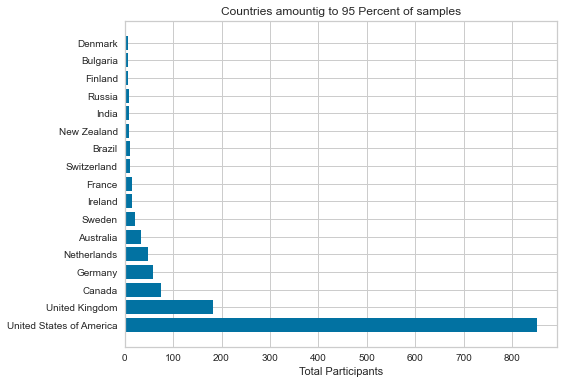

In [8]:
df_top_95_countries_full_ordered =df_top_95_countries_full["country_work"].value_counts().to_frame().reset_index()
y_pos = np.arange(len(df_top_95_countries_full_ordered["index"]))


plt.barh(y_pos, df_top_95_countries_full_ordered["country_work"], alpha=1)
plt.yticks(y_pos, df_top_95_countries_full_ordered["index"])
plt.xlabel('Total Participants')
plt.title('Countries amountig to 95 Percent of samples')

plt.tight_layout()
plt.show()

Getting all the columns in the same form. Hence I will be using gower-distance, categorial and ordinal data can be stored as words. 
Furthermore changing the object type to category type, so that I can create ordinal data structures.

In [9]:
df["mental_health_proffesional_treatment"].replace((1, 0), ('Yes', 'No'), inplace=True)
df["previous_companies"].replace((1, 0), ('Yes', 'No'), inplace=True)
df["self_employed"].replace((1, 0), ('Yes', 'No'), inplace=True)

for x in df:
    if df[x].dtype == "object":
        df[x] = df[x].astype('category')


In [10]:
# creating ordinal features where it makes sense.
cat_type = CategoricalDtype(categories=['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'], ordered=True)
df["number_of_employees"] = df["number_of_employees"].astype(cat_type)
cat_type = CategoricalDtype(categories=['1-25%', '26-50%','51-75%', '76-100%'], ordered=True)
df["mental_health_productivity_impact_percent"] = df["mental_health_productivity_impact_percent"].astype(cat_type)
cat_type = CategoricalDtype(categories=['None did', 'Some did', 'Yes, they all did'], ordered=True)
df["previous_companies_mental_health_resources"] = df["previous_companies_mental_health_resources"].astype(cat_type)
cat_type = CategoricalDtype(categories=['None of them', 'Some of them', 'Yes, all of them'], ordered=True)
df["previous_companies_physical_health_discussion_negative_impact"] = df["previous_companies_physical_health_discussion_negative_impact"].astype(cat_type)
cat_type = CategoricalDtype(categories=['No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'], ordered=True)
df["previous_companies_mental_coworkers_health_discussion"] = df["previous_companies_mental_coworkers_health_discussion"].astype(cat_type)
cat_type = CategoricalDtype(categories=['None of them', 'Some of them', 'Yes, all of them'], ordered=True)
df["previous_company_mental_health_coworker_discussion_negative_impact"] = df["previous_company_mental_health_coworker_discussion_negative_impact"].astype(cat_type)
cat_type = CategoricalDtype(categories=['Never', 'Sometimes', 'Always'], ordered=True)
df["remote"] = df["remote"].astype(cat_type)


Checking what features have too many different values and might therefore be deleted or processed otherwise

In [11]:
for x in df.columns:
    if len(df[x].value_counts(dropna=False)) > 10:
        print(x, len(df[x].value_counts(dropna=False))) 

why/why_not 1086
why/why_not2 1081
yes:what_diagnosis 129
maybe:what_diagnosis 100
yes:condition_diagnosed 117
age 53
sex 71
country_live 53
live_us_territory 48
country_work 53
work_us_territory 49
work_position 264


In [12]:
data = pd.crosstab(df['maybe:what_diagnosis'], df['yes:condition_diagnosed'], margins = False)

contingency = pd.crosstab(df['country_work'], df['country_live'])
stat, p, dof, expected = stats.chi2_contingency(contingency)

alpha = 0.05

print('Significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('-> Variables are associated')
else:
    print('-> Variables are not associated')

Significance=0.050, p=0.000
-> Variables are associated


In [13]:
data = pd.crosstab(df['yes:what_diagnosis'], df['yes:condition_diagnosed'], margins = False) 
contingency = pd.crosstab(df['country_work'], df['country_live'])
stat, p, dof, expected = stats.chi2_contingency(contingency)

alpha = 0.05

print('Significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('-> Variables are associated')
else:
    print('-> Variables are not associated')

Significance=0.050, p=0.000
-> Variables are associated


Checking if df['country_work'] and df['country_live'] are dependent on each other, so that one could be deleted.

In [14]:
data = pd.crosstab(df['country_work'], df['country_live'], margins = False)

contingency = pd.crosstab(df['country_work'], df['country_live'])
stat, p, dof, expected = stats.chi2_contingency(contingency)

alpha = 0.05

print('Significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('-> Variables are associated')
else:
    print('-> Variables are not associated')

Significance=0.050, p=0.000
-> Variables are associated


In [15]:
df_ohe_reverse_colum_diagnosis = df["yes:what_diagnosis"].copy()
df_ohe_reverse_colum_work_position = df["work_position"].copy()

In [16]:
# Everything above 10 is considered to be deleted. E.g. [why/why_not  why/why_not2]. Features that contain basically the same information like yes:what_diagnosis, maybe:what_diagnosis, 
# yes:condition diagnosed are deleted but one (yes:condition_diagnosed) is kept and will be processed further. Reason is, that it is the mental ilness diagnosed by a doctor. country_live is dropped, 
# but country work is kept. ´live_us_territory is deleted hence it contains information only for some rows of the dataset. work_position becomes vectorized like yes:condition_diagnosed 
# and is therefore kept.

df.drop(columns=["why/why_not", "why/why_not2", "live_us_territory", "work_us_territory", "country_live", "work_us_territory", 'yes:what_diagnosis', 'maybe:what_diagnosis'], inplace=True)


Cleaning up the age column

In [17]:
mean_age =df["age"].mean()
df.loc[df['age'] <= 18, 'age'] = mean_age
df.loc[df['age'] >= 75, 'age'] = mean_age
mean_corrected = df["age"].mean()
df.loc[df['age'] <= 18, 'age'] = mean_corrected
df.loc[df['age'] >= 75, 'age'] = mean_corrected

Cleaning up the gender field

In [18]:
df['sex'] = df['sex'].str.lower()
df["sex"] = df["sex"].str.strip()

gender_male_freeform = ['cis male','maile', 'Make', 'Mal', 'Cis Man','cis man', 'man', 'sex is male', 'Male', 'male', 'ostensibly male, unsure what that really means', 'male.', 'M', 'Malr', 'malr', 
'Cis Male', 'm', 'mail','male (cis)', 'msle', 'Mail', 'male ', 'dude']

gender_female_freeform = ['cis female', 'cis-female/femme', 'i identify as female.', 'F', 'Woman', 'female (props for making this a freeform field, though)', 'female assigned at birth', 
'female', 'woman', 'femail', 'Female', 'Femake', 'Female (cis)', 'cis-woman', 'cisgender female', 'female/woman', 'f', 'female-bodied; no feelings about gender', 'fm', ' female', 'cis female']

sex_undefined_freeform = (df["sex"].value_counts().index[2:].to_list())

df["sex"] = df["sex"].replace(gender_male_freeform, 'male')
df["sex"] = df["sex"].replace(gender_female_freeform, 'female')
df["sex"] = df["sex"].replace(sex_undefined_freeform, 'other')
df["sex"] = df["sex"].astype('category')

Cleaning up and Vectorizing the Work_Position_Field

In [19]:
df['work_position'] = df['work_position'].str.lower()
df["work_position"] = df["work_position"].str.strip()

work_list_to_be_set = df["work_position"].value_counts().index.to_list()

#Creating a set of unique work descriptions and cleansing it befor vectorizing.
work_list_split = [item.split('|') for item in work_list_to_be_set]

work_list_flat = [item for l in work_list_split for item in l]
set_of_work_list_flat = set(work_list_flat)

set_of_work_list_flat = list(set_of_work_list_flat)

set_of_work_list_flat = [i.replace("-", "") for i in set_of_work_list_flat]
set_of_work_list_flat = [i.replace("/", "") for i in set_of_work_list_flat]
set_of_work_list_flat = [i.replace(" ", "") for i in set_of_work_list_flat]

# cleaning the work list to vectorize it with the set of work descriptions
work_list_full = df["work_position"].to_list()
work_list_full = [i.replace("-", "") for i in work_list_full]
work_list_full = [i.replace("/", "") for i in work_list_full]
work_list_full = [i.replace(" ", "") for i in work_list_full]
work_list_full = [i.replace("|", ", ") for i in work_list_full]

# the actual vectorizing
corpus = work_list_full
cv = CountVectorizer(vocabulary=set_of_work_list_flat, lowercase=True)
X = cv.fit_transform(corpus)
array_worklist = X.toarray()

df_work_list = pd.DataFrame(array_worklist)
df_work_list.columns = set_of_work_list_flat


Cleaning up and vectorizing the yes:condition_diagnosed field.

In [20]:
df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.lower()
df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.strip()
df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.replace(r"\s+\(.*\)","")
df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.replace(r"\s+\-","")
df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.replace(r"\"", "")
df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.replace(r"\,", "")
df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.replace(r'posttraumatic stress disourder', 'post-traumatic stress disorder')
df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.replace(r'depression', 'mood disorder')
df['yes:condition_diagnosed'].fillna("healthy", inplace=True)

asperger_list = ['asperger spectrum disorder', 'autism spectrum disorder', 'asperger syndrome', 'aspergers', 'autism while not a mental illness still greatly affects how i handle anxiety', 'autism'] 
adhd_list = ['attention deficit disorder','attention deficit hyperactivity disorder', 'add', 'mcd', ]
personality_disorder = ['pdd-nos \(see above\)', 'pdd-nos']
gender_list = ['gender dysphoria','gender identity disorder','intimate disorder',]
mood_disorder_list = ["depression", "seasonal affective disorder"]

df = df.replace({'yes:condition_diagnosed': asperger_list}, {'yes:condition_diagnosed': 'spectrumdisorder'}, regex=True)
df = df.replace({'yes:condition_diagnosed': adhd_list}, {'yes:condition_diagnosed': 'adhd'}, regex=True)
df = df.replace({'yes:condition_diagnosed': personality_disorder}, {'yes:condition_diagnosed': 'personality disorder'}, regex=True)
df = df.replace({'yes:condition_diagnosed': gender_list}, {'yes:condition_diagnosed': 'gender disorder'}, regex=True)
df = df.replace({'yes:condition_diagnosed': mood_disorder_list}, {'yes:condition_diagnosed': 'mood disorder'}, regex=True)


#Creating a set of unique condition descriptions and cleansing it befor vectorizing.
condition_list_to_be_set = df["yes:condition_diagnosed"].value_counts().index.to_list()
condition_list_split = [item.split('|') for item in condition_list_to_be_set]

condition_list_flat = [item for l in condition_list_split for item in l]
set_of_condition_list_flat = set(condition_list_flat)
set_of_condition_list_flat_check = set(condition_list_flat)

set_of_condition_list_flat = list(set_of_condition_list_flat)

set_of_condition_list_flat = [i.replace("-", "") for i in set_of_condition_list_flat]
set_of_condition_list_flat = [i.replace("/", "") for i in set_of_condition_list_flat]
set_of_condition_list_flat = [i.replace(" ", "") for i in set_of_condition_list_flat]


# cleaning the condition list to vectorize it with the set of condition descriptions
condition_list_full = df["yes:condition_diagnosed"].to_list()

condition_list_full = [str(i).replace("-", "") for i in condition_list_full]
condition_list_full = [str(i).replace("/", "") for i in condition_list_full]
condition_list_full = [str(i).replace(" ", "") for i in condition_list_full]
condition_list_full = [str(i).replace("|", ", ") for i in condition_list_full]

corpus = condition_list_full
cv = CountVectorizer(vocabulary=set_of_condition_list_flat, lowercase=True)
X = cv.fit_transform(corpus)

array_condition_list = X.toarray()

df_condition_list = pd.DataFrame(array_condition_list)
df_condition_list.columns = set_of_condition_list_flat



C:\Users\Max_G\AppData\Local\Temp/ipykernel_27748/1056414567.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.replace(r"\s+\(.*\)","")
C:\Users\Max_G\AppData\Local\Temp/ipykernel_27748/1056414567.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.replace(r"\s+\-","")
C:\Users\Max_G\AppData\Local\Temp/ipykernel_27748/1056414567.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.replace(r"\"", "")
C:\Users\Max_G\AppData\Local\Temp/ipykernel_27748/1056414567.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['yes:condition_diagnosed'] = df['yes:condition_diagnosed'].str.replace(r"\,", "")


Splitting up the dataframes in different branches to see how column or row dropping impacts the final silhouette score.

In [21]:
#Two df to be created: Dropping rare countries or keeping it.


dataframes_dict = {}
df_all_countries = df.copy()

dataframes_dict["all_countries"] = df_all_countries
print("original lenght", len(dataframes_dict["all_countries"]))

#Dropping rare countries
coutry_list = df["country_work"].value_counts().index[0:5].to_list()
df_no_rare_countries = df.loc[df['country_work'].isin(coutry_list)].copy()

dataframes_dict["df_no_rare_countries"] = df_no_rare_countries.copy()
print("lenght after country_work drop", len(dataframes_dict["df_no_rare_countries"]))

#deleting the not used df's to safe space.
df_no_rare_countries = pd.DataFrame()

original lenght 1433
lenght after country_work drop 1213


replacing nans I can identify meaningful with meaningful values.

In [22]:
# the idea is,that plenty of columns are missing values hence they are self-employed or its their first job. Therefore I will replace nans in these brach 
# of dataframes with meaningful variables.

#creating of the branch

name_list = ["all_countries_filled", "df_no_rare_countries_filled"]
transform_dict = {}

for x in dataframes_dict:
    transform_dict[x] = dataframes_dict[x].copy()

for x, y in zip(transform_dict, name_list):
    dataframes_dict[y] = transform_dict[x].copy()
    

# deleting the copy tool again to safe space    
transform_dict = {}

In [23]:
# substituting the nan values

for x in dataframes_dict:
    if x in name_list:
        list_values_self_employed =  dataframes_dict[x]["self_employed"].value_counts().to_list()
        list_values_previous_companies = dataframes_dict[x]["previous_companies"].value_counts().to_list()

        df_transform = pd.DataFrame()
        df_transform = dataframes_dict[x].isna().sum().to_frame()
        df_transform.reset_index(inplace=True)
        df_transform.columns = ["column_names", "isnanumber"]

        list_of_self_employed = df_transform.loc[df_transform['isnanumber'] == list_values_self_employed[1], 'column_names'].to_list()
        print(f"The following colums conatining {list_values_self_employed[1]} nan values have been replacecd with self_employed in {x}. \
        If they are self employed there answer in these columns is nan:\n", list_of_self_employed)


        for y in list_of_self_employed:
            dataframes_dict[x][y] = dataframes_dict[x][y].replace(np.nan, "self_employed")

        list_of_previous_companies_columns = df_transform.loc[df_transform['isnanumber'] == list_values_previous_companies[1], 'column_names'].to_list()

        for y in list_of_previous_companies_columns:
             dataframes_dict[x][y] = dataframes_dict[x][y].replace(np.nan, "first_job")

        print(f"\n The following colums conatining {list_values_previous_companies[1]} nan values have been replacecd with first_job in {x}. If this is their \
        first job, their answer in these columns is nan:\n", list_of_previous_companies_columns)

    else:
        pass


The following colums conatining 287 nan values have been replacecd with self_employed in all_countries_filled.         If they are self employed there answer in these columns is nan:
 ['number_of_employees', 'company_in_tech', 'company_mental_health', 'company_mental_health_discussion', 'company_mental_health_resources', 'company_mental_health_anonymity', 'company_mental_health_leave', 'company_mental_health_discussion_impact', 'company_physical_health_discussion_negative_impact', 'mental_health_coworkers_discussion', 'mental_health_supervisor_discussion', 'company_mental_health_serious', 'company_mental_health_coworker_discussion_negative_impact']

 The following colums conatining 169 nan values have been replacecd with first_job in all_countries_filled. If this is their         first job, their answer in these columns is nan:
 ['previous_companies_mental_health_benefits', 'previous_companies_mental_health_benefits_awareness', 'previous_companies_mental_health_discussion', 'previous_c

Creating another branch, to see how that impacts the clustering

In [24]:
# this branch consists of the df with all countries but missing values are simply imputed. Its obviously a bad choice, but I want to see what it does.

dataframes_dict["all_countries_imputed"] = dataframes_dict["all_countries"].copy()

for x in dataframes_dict["all_countries_imputed"]:
    dataframes_dict["all_countries_imputed"][x].fillna(dataframes_dict["all_countries_imputed"][x].mode()[0], inplace = True)

Dropping the columns with nan values of more than 10 percent. Imputing columns which have nan values between 0 and 10 percent.

In [25]:
for x in dataframes_dict:
    
    cols = dataframes_dict[x].columns[dataframes_dict[x].isna().mean()>0.1]
    print(f"The following collumn in {x}, containing more than 10% nan values, which couldn't be accounted for where dropped: {cols.to_list()}")
    dataframes_dict[x].drop(cols, axis=1, inplace=True)


    df_transformed = dataframes_dict[x].isna().mean().to_frame()
    df_transformed.reset_index(inplace=True)
    df_transformed.columns = ["column", "percentage"]
    df_transformed_list = df_transformed.query('0 < percentage <= 0.1')["column"].to_list()

    print(f"The following collums contain < 0 but <= 0.1 percentage of na values {df_transformed_list} and will be imputed with mode value")

    for y in df_transformed_list: 
        dataframes_dict[x][y].fillna(dataframes_dict[x][y].mode()[0], inplace = True)
    
#checking if no more nan are left.

    df_check = dataframes_dict[x].isna().sum().to_frame().reset_index()
    df_check.columns = ["column", "nan"] 
    if df_check["nan"].sum() == 0:
        print("No more nan values left")


The following collumn in all_countries, containing more than 10% nan values, which couldn't be accounted for where dropped: ['number_of_employees', 'company_in_tech', 'role_in_tech', 'company_mental_health', 'company_mental_health_options_awareness', 'company_mental_health_discussion', 'company_mental_health_resources', 'company_mental_health_anonymity', 'company_mental_health_leave', 'company_mental_health_discussion_impact', 'company_physical_health_discussion_negative_impact', 'mental_health_coworkers_discussion', 'mental_health_supervisor_discussion', 'company_mental_health_serious', 'company_mental_health_coworker_discussion_negative_impact', 'mental_health_coverage', 'mental_health_online_resources', 'mental_health_diagnosed_reveal', 'mental_health_diagnosed_reveal_impact', 'mental_health_diagnosed_coworker_reveal', 'mental_health_diagnosed_coworker_reveal_impact_negative', 'mental_health_productivity_impact', 'mental_health_productivity_impact_percent', 'previous_companies_menta

In [26]:
#dropping the "yes:condition_diagnosed", "work_position" columns since they are of too high cardinality.

df_ohe_prepare_for_reverse = dataframes_dict["all_countries"].copy()

for x in dataframes_dict:
    dataframes_dict[x]= dataframes_dict[x].drop(["yes:condition_diagnosed", "work_position"], axis=1)


# creating another dataframe for the hierarchical clustering
dataframes_dict["all_countries_hierarchical"] = dataframes_dict["all_countries"].copy()

Creating a dataframe, with one hot encoding.

In [135]:
# I have to drop the country work column for OHE hence gower canot work with so many different columns.

dataframes_dict["df_ohe_w/o_bow_features"] = dataframes_dict["all_countries"].copy()


column_list = []
for x in dataframes_dict["df_ohe_w/o_bow_features"]:
    if x == "age":
        pass
    else:
        column_list.append(x)

dataframes_dict["df_ohe_w/o_bow_features"] = pd.get_dummies(dataframes_dict["df_ohe_w/o_bow_features"], prefix=column_list, columns=column_list)
dataframes_dict["df_ohe_with_bow_features"] = dataframes_dict["df_ohe_w/o_bow_features"].copy()
dataframes_dict["df_ohe_with_bow_features"] = pd.concat((dataframes_dict["df_ohe_with_bow_features"], df_work_list), axis=1)
dataframes_dict["df_ohe_with_bow_features"] = pd.concat((dataframes_dict["df_ohe_with_bow_features"], df_condition_list), axis=1)

#copying it for the pca.

df_ohe_pca_dict = {}
df_ohe_pca_dict["df_ohe_w/o_bow_features"] = dataframes_dict["df_ohe_w/o_bow_features"].copy()
df_ohe_pca_dict["df_ohe_with_bow_features"] = dataframes_dict["df_ohe_with_bow_features"].copy()

Creating a list to tell gower distance what columns contain categorial data (ordinal + nominal) and which contain numeric values.

In [28]:
cat_dict = {}
cat_list = []

for dataframe in dataframes_dict:
    for column in dataframes_dict[dataframe]:
        for column in dataframes_dict[dataframe].columns:
            if dataframes_dict[dataframe].columns.get_loc("age") == dataframes_dict[dataframe].columns.get_loc(column):
                cat_list.append(False)
            else:
                cat_list.append(True)
        cat_dict[dataframe] = cat_list
        cat_list = []

Calculating the gower matrix for all dataframes within the dictionary

In [29]:
for x in dataframes_dict:
    print(f"The following dataframes will have gower matrices created {x}")

gower_matrix_dict= {}
for df_name in dataframes_dict:
    gower_matrix_dict[df_name] = gower.gower_matrix(dataframes_dict[df_name], cat_features=cat_dict[df_name])

The following dataframes will have gower matrices created all_countries
The following dataframes will have gower matrices created df_no_rare_countries
The following dataframes will have gower matrices created all_countries_filled
The following dataframes will have gower matrices created df_no_rare_countries_filled
The following dataframes will have gower matrices created all_countries_imputed
The following dataframes will have gower matrices created all_countries_hierarchical
The following dataframes will have gower matrices created df_ohe_w/o_bow_features
The following dataframes will have gower matrices created df_ohe_with_bow_features


Calculationg the gower matrix for the ohe dataframe. Calculating the optimal silhouete score, and perform clustering with dbscan.

Calculationg optimal silhouete scores

In [32]:
#calculating the optimal parameters for the optimal silhouete score.

eps_list = []
for i in np.linspace(0.1, 0.3, num=29):
    eps_list.append(i.round(2))

min_sampe_list = [x for x in range(2, 11 , 1)]

data_all = []

for df_name in dataframes_dict:
    for eps_value in eps_list:
        data1 = []
        data2 = []
        for min_sample in min_sampe_list:
            dbscan_cluster = DBSCAN(eps=eps_value, 
                            min_samples=min_sample, 
                            metric="precomputed")

            dbscan_cluster.fit(gower_matrix_dict[df_name])
    
            dataframes_dict[df_name]["cluster"] = dbscan_cluster.labels_
            no_of_clusters = dataframes_dict[df_name]["cluster"].nunique()

            data1.append(df_name)
            data1.append(eps_value)
            data1.append(min_sample)
            score = np.nan
            try:
                score = metrics.silhouette_score(gower_matrix_dict[df_name], dbscan_cluster.labels_)
            except: ValueError
            data1.append(no_of_clusters)
            data1.append(score)
            
            
            data2 = [data1]
            data_all.extend(data2)
            data1 = []
            date2 = []  

df_silhouette_score = pd.DataFrame(data_all, columns=["df_name", 'eps_value', 'min_sample', '# of clusters', 'score']) 

In [33]:
# creating a dictionary for all the silhouette_score dataframes by name of the coresponding dataframe.

df_silhouette_score_clustered = {}

for df_name in dataframes_dict:
    df_silhouette_score_clustered[df_name] = df_silhouette_score.loc[df_silhouette_score['df_name'] == df_name] 

In [34]:
#creating a dictionary conatining all the optimal values, so that dbscan can use them.

best_parameters_dict = {}

for x in df_silhouette_score_clustered:
    best_parameters_dict[x] = {}

for x in df_silhouette_score_clustered:
    best_parameters_dict[x]["best_eps_value"] = df_silhouette_score_clustered[x].loc[df_silhouette_score_clustered[x]['score'].idxmax()][1]
    best_parameters_dict[x]["best_min_sample"] = df_silhouette_score_clustered[x].loc[df_silhouette_score_clustered[x]['score'].idxmax()][2]
    best_parameters_dict[x]["no_of_clusters"] = df_silhouette_score_clustered[x].loc[df_silhouette_score_clustered[x]['score'].idxmax()][3]
    best_parameters_dict[x]["silhouette_score"] = df_silhouette_score_clustered[x].loc[df_silhouette_score_clustered[x]['score'].idxmax()][4]


for x in df_silhouette_score_clustered:
    print(f"The dataframe {x}, has the following values")
    print("best_eps_value =", best_parameters_dict[x]["best_eps_value"])
    print("best_min_sample =",  best_parameters_dict[x]["best_min_sample"])
    print("no_of_clusters =", best_parameters_dict[x]["no_of_clusters"])
    print("silhouette_score =", best_parameters_dict[x]["silhouette_score"])

    



The dataframe all_countries, has the following values
best_eps_value = 0.19
best_min_sample = 8
no_of_clusters = 3
silhouette_score = 0.17533428966999054
The dataframe df_no_rare_countries, has the following values
best_eps_value = 0.19
best_min_sample = 8
no_of_clusters = 3
silhouette_score = 0.18802569806575775
The dataframe all_countries_filled, has the following values
best_eps_value = 0.2
best_min_sample = 9
no_of_clusters = 3
silhouette_score = 0.12795624136924744
The dataframe df_no_rare_countries_filled, has the following values
best_eps_value = 0.2
best_min_sample = 8
no_of_clusters = 3
silhouette_score = 0.1450720578432083
The dataframe all_countries_imputed, has the following values
best_eps_value = 0.23
best_min_sample = 9
no_of_clusters = 2
silhouette_score = 0.07178375124931335
The dataframe all_countries_hierarchical, has the following values
best_eps_value = 0.19
best_min_sample = 8
no_of_clusters = 3
silhouette_score = 0.17533428966999054
The dataframe df_ohe_w/o_bow_f

In [35]:
# the actual clustering for all the dataframes with the optimal values. Coffee time.

dbscan_cluster_dict_best_fit = {}

for x in best_parameters_dict:
    dbscan_cluster_dict_best_fit[x] = DBSCAN(eps=best_parameters_dict[x]["best_eps_value"], 
                            min_samples=best_parameters_dict[x]["best_min_sample"], 
                            metric="precomputed")
    

for x in dbscan_cluster_dict_best_fit:
    dbscan_cluster_dict_best_fit[x].fit(gower_matrix_dict[x])
    dataframes_dict[x]["cluster"] = dbscan_cluster_dict_best_fit[x].labels_


# Tried to plot a silhouette score visualization. Yellowbrick unfortunately doesn’t work with dbscan.

Preparing a dictionary for EDA.

In [41]:
cluster_list = []

dataframes_dict["df_ohe_with_bow_features"] = pd.concat((df_ohe_prepare_for_reverse, dataframes_dict["df_ohe_with_bow_features"]["cluster"]), axis =1)
dataframes_dict["df_ohe_w/o_bow_features"] = pd.concat((df_ohe_prepare_for_reverse, dataframes_dict["df_ohe_w/o_bow_features"]["cluster"]), axis=1)


# dataframes_dict["df_ohe_reverse"] = df_ohe_reverse
# dataframes_dict["df_ohe_reverse"] = pd.concat((dataframes_dict["df_ohe_reverse"], df_ohe_reverse_colum_diagnosis, df_ohe_reverse_colum_work_position), axis = 1)


# creating a list of the cluster lists.
for x in dataframes_dict:
    sub_list =[]
    for y in dataframes_dict[x]["cluster"].unique():
        sub_list.append(y)
    cluster_list.extend([sub_list])    

# creating a dictionary of the corresponding cluster lists.
cluster_list_dict = {}
for list, df_name, in zip(cluster_list, dataframes_dict):
    cluster_list_dict[df_name]= list

# creating a sub-dictionary of clustered dataframes.
dataframes_clustered = {}
for df_name, list in zip(dataframes_dict, cluster_list):
    dataframes_clustered[df_name] = {}
    
    for list in cluster_list:
        for number in list:
            dataframes_clustered[df_name][number] = dataframes_dict[df_name].loc[dataframes_dict[df_name]["cluster"] == number]
            if len(dataframes_clustered[df_name][number]) == 0:
                del dataframes_clustered[df_name][number]

  


In [121]:
pd.set_option("display.max_rows", 50, "display.max_columns", 50)

df_clustered_analysis = {}

for df_name in dataframes_clustered:
    df_clustered_analysis[df_name] = {}
    for cluster in dataframes_clustered[df_name]:
        data1 = []
        data2 = []
        data_all = []
        for column in dataframes_clustered[df_name][cluster]:
            data1.append(column)
            data1.append(dataframes_clustered[df_name][cluster][column].mode().to_list()[0])
            data1.append(dataframes_clustered[df_name][cluster][column].value_counts().to_list()[0]/len(dataframes_clustered[df_name][cluster]))
            data2 = [data1]
            data_all.extend(data2)
            data1 = []
            date2 = []
    
        df_clustered_analysis[df_name][cluster] = pd.DataFrame(data_all, columns=['column', 'mode', 'relative frequency'])
        df_clustered_analysis[df_name][cluster].sort_values(by=['relative frequency'], inplace=True, ascending=False)




In [43]:
df_visualisation_cluster_0 = df_clustered_analysis["all_countries"][0].drop(df_clustered_analysis["all_countries"][0][df_clustered_analysis["all_countries"][0].column == "cluster"].index)
df_visualisation_cluster_0.at[7, "column"] = "prev._a._cur._company_healt_bad_exp." 
df_visualisation_cluster_1 = df_clustered_analysis["all_countries"][1].drop(df_clustered_analysis["all_countries"][1][df_clustered_analysis["all_countries"][1].column == "cluster"].index)
df_visualisation_cluster_1.at[7, "column"] = "prev._a._cur._company_healt_bad_exp." 
df_visualisation_cluster__1 = df_clustered_analysis["all_countries"][-1].drop(df_clustered_analysis["all_countries"][-1][df_clustered_analysis["all_countries"][-1].column == "cluster"].index)
df_visualisation_cluster__1.at[7, "column"] = "prev._a._cur._company_healt_bad_exp." 




df_visualisation_cluster_0 = df_visualisation_cluster_0.reset_index().drop(columns="index", axis = 1)
df_visualisation_cluster_1 = df_visualisation_cluster_1.reset_index().drop(columns="index", axis = 1)
df_visualisation_cluster__1 = df_visualisation_cluster__1.reset_index().drop(columns="index", axis = 1)

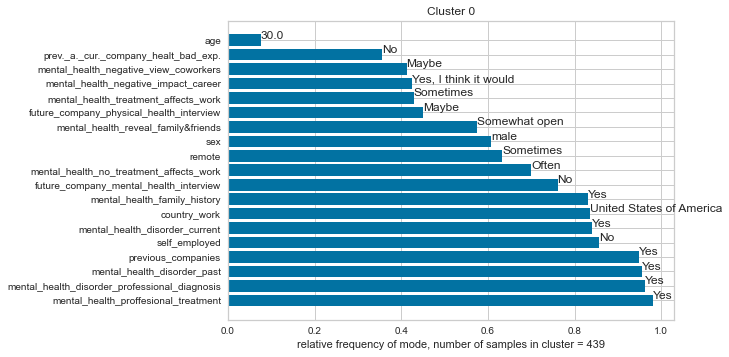

<Figure size 40000x4000 with 0 Axes>

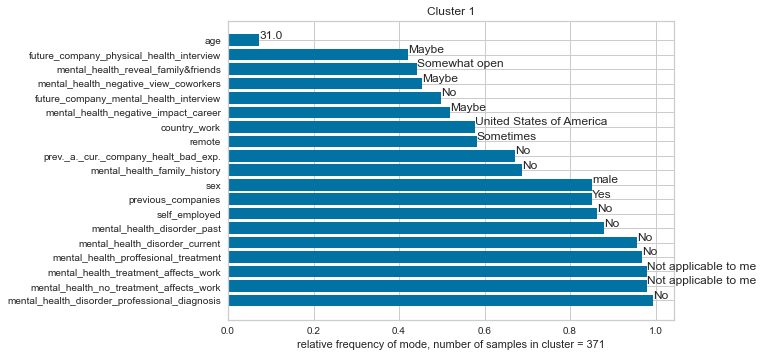

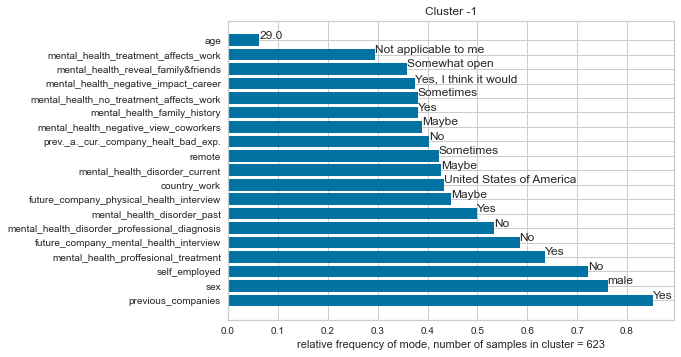

In [46]:
# plotting cluster 0 
y_pos = np.arange(len(df_visualisation_cluster_0["column"]))

plt.barh(y_pos, df_visualisation_cluster_0["relative frequency"], alpha=1)
plt.yticks(y_pos, df_visualisation_cluster_0["column"])
plt.xlabel(f'relative frequency of mode, number of samples in cluster = {len(dataframes_clustered["all_countries"][0])}')
plt.title('Cluster 0')

for y, mode in zip(range(len(df_visualisation_cluster_0["column"])), df_visualisation_cluster_0["mode"]):
    plt.text(df_visualisation_cluster_0["relative frequency"][y], y, mode, va="bottom")

#plt.tight_layout()
plt.figure(dpi=400, figsize=(100, 10))  
plt.show()

# plotting cluster 1
y_pos = np.arange(len(df_visualisation_cluster_1["column"]))

plt.barh(y_pos, df_visualisation_cluster_1["relative frequency"], alpha=1)
plt.yticks(y_pos, df_visualisation_cluster_1["column"])
plt.xlabel(f'relative frequency of mode, number of samples in cluster = {len(dataframes_clustered["all_countries"][1])}')
plt.title('Cluster 1')

for y, mode in zip(range(len(df_visualisation_cluster_1["column"])), df_visualisation_cluster_1["mode"]):
    plt.text(df_visualisation_cluster_1["relative frequency"][y], y, mode, va="bottom")

plt.show()

# plotting cluster -1
y_pos = np.arange(len(df_visualisation_cluster__1["column"]))

plt.barh(y_pos, df_visualisation_cluster__1["relative frequency"], alpha=1)
plt.yticks(y_pos, df_visualisation_cluster__1["column"])
plt.xlabel(f'relative frequency of mode, number of samples in cluster = {len(dataframes_clustered["all_countries"][-1])}')
plt.title('Cluster -1')


for y, mode in zip(range(len(df_visualisation_cluster__1["column"])), df_visualisation_cluster__1["mode"]):
    plt.text(df_visualisation_cluster__1["relative frequency"][y], y, mode, va="bottom")

plt.show()

Trying Agglomerative Clustering to see if it performs

In [47]:
n_cluster_list = [x for x in range(2, 11, 1)]
list_method = ['complete', 'average', 'single'] #  'ward'

hierarchical_cluster_dict = {}
clusters_dict = {}
score_list = []
data_all = []
data1 = []
data2 = []  

for x in list_method:
    hierarchical_cluster_dict[x] = {}
    clusters_dict[x] = {}


for x in list_method:
    for y in n_cluster_list:
        hierarchical_cluster_dict[x][y] = AgglomerativeClustering(n_clusters=y, affinity='precomputed', linkage=x)
        clusters_dict[x][y] = hierarchical_cluster_dict[x][y].fit_predict(gower_matrix_dict["all_countries"])
        dataframes_dict["all_countries_hierarchical"]["cluster"] = hierarchical_cluster_dict[x][y].labels_ 
        
        data1.append(x)
        data1.append(y)
        score = np.nan
        try:
            score = metrics.silhouette_score(gower_matrix_dict["all_countries_hierarchical"], hierarchical_cluster_dict[x][y].labels_)
        except: ValueError
        data1.append(score)
            
            
        data2 = [data1]
        data_all.extend(data2)
        data1 = []
        date2 = []  

df_silhouette_score_hierarchical = pd.DataFrame(data_all, columns=['method', 'no. of cluster', 'score']) 
df_silhouette_score_hierarchical.sort_values(by="score", inplace=True, ascending=False)
print(df_silhouette_score_hierarchical.loc[df_silhouette_score_hierarchical['score'].idxmax()])

method             average
no. of cluster           2
score             0.375525
Name: 9, dtype: object


In [48]:
# find the top four combinations of no of clusters and method

df_silhouette_score_hierarchical_eda = df_silhouette_score_hierarchical[:4]
method_list = []
cluster_list_1 = []

for x, y in zip(df_silhouette_score_hierarchical_eda["method"], df_silhouette_score_hierarchical_eda["no. of cluster"]):
    method_list.append(x)
    cluster_list_1.append(y)

In [49]:
df_silhouette_score_hierarchical_eda["option"] = [1, 2, 3, 4]

C:\Users\Max_G\AppData\Local\Temp/ipykernel_27748/2572557118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_silhouette_score_hierarchical_eda["option"] = [1, 2, 3, 4]


In [50]:
# creating a dictionary with the top four clustering optinons.

print("Creating dataframes for the following methods\n", 
df_silhouette_score_hierarchical_eda)

dataframes_dict_hierarchical = {}

options = [x for x in range(1,5,1)]

for x in options:
    dataframes_dict_hierarchical[x] = dataframes_dict["all_countries_hierarchical"].copy()

# cluster the top four methods

for x, y, z in zip(method_list, cluster_list_1, options):
    hierarchical_cluster = AgglomerativeClustering(n_clusters=y, affinity='precomputed', linkage=x)
    hierarchical_cluster.fit_predict(gower_matrix_dict["all_countries_hierarchical"])
    dataframes_dict_hierarchical[z]["cluster"] = hierarchical_cluster.labels_ 
        

Creating dataframes for the following methods
       method  no. of cluster     score  option
9    average               2  0.375525       1
0   complete               2  0.360117       2
10   average               3  0.285326       3
11   average               4  0.209963       4


Let's see how the dendogram looks.

In [ ]:
plt.figure(dpi=200, figsize=(10, 10))  
plt.title("Dendrograms")  
dend = dendrogram(linkage(gower_matrix_dict["all_countries_hierarchical"], method='average'))

In [51]:
cluster_list =[]

for x in dataframes_dict_hierarchical:
    sub_list =[]
    for y in dataframes_dict_hierarchical[x]["cluster"].unique():
        sub_list.append(y)
    cluster_list.extend([sub_list])    

# creating a dictionary of the corresponding cluster lists.
cluster_list_dict = {}
for list1, df_name, in zip(cluster_list, dataframes_dict_hierarchical):
    cluster_list_dict[df_name]= list1

# creating a sub-dictionary of clustered dataframes.
dataframes_dict_hierarchical_clustered = {}
for df_name, list1 in zip(dataframes_dict_hierarchical, cluster_list):
    dataframes_dict_hierarchical_clustered[df_name] = {}
    
    for list1 in cluster_list:
        for number in list1:
            dataframes_dict_hierarchical_clustered[df_name][number] = dataframes_dict_hierarchical[df_name].loc[dataframes_dict_hierarchical[df_name]["cluster"] == number]
            if len(dataframes_dict_hierarchical_clustered[df_name][number]) == 0:
                del dataframes_dict_hierarchical_clustered[df_name][number]

In [52]:
#creating a dictionary containing the analysed results of the clusterings.


pd.set_option("display.max_rows", 50, "display.max_columns", 50)

df_hierarchical_clustered_analysis = {}

for option in dataframes_dict_hierarchical_clustered:
    df_hierarchical_clustered_analysis[option] = {}
    for cluster in dataframes_dict_hierarchical_clustered[option]:
        data1 = []
        data2 = []
        data_all = []
        for column in dataframes_dict_hierarchical_clustered[option][cluster]:
            data1.append(column)
            data1.append(dataframes_dict_hierarchical_clustered[option][cluster][column].mode().to_list()[0])
            data1.append(dataframes_dict_hierarchical_clustered[option][cluster][column].value_counts().to_list()[0]/len(dataframes_dict_hierarchical_clustered[option][cluster]))
            data2 = [data1]
            data_all.extend(data2)
            data1 = []
            date2 = []
    
        df_hierarchical_clustered_analysis[option][cluster] = pd.DataFrame(data_all, columns=['column', 'mode', 'relative frequency'])
        df_hierarchical_clustered_analysis[option][cluster].sort_values(by=['relative frequency'], inplace=True, ascending=False)




In [53]:
df_visualisation_hierachical = {}

for option in df_hierarchical_clustered_analysis:
    df_visualisation_hierachical[option] = {}
    for cluster in df_hierarchical_clustered_analysis[option]:
        df_visualisation_hierachical[option][cluster] = df_hierarchical_clustered_analysis[option][cluster].drop(df_hierarchical_clustered_analysis[option][cluster][df_hierarchical_clustered_analysis[option][cluster].column == "cluster"].index)
        df_visualisation_hierachical[option][cluster] = df_visualisation_hierachical[option][cluster].reset_index().drop(columns="index", axis = 1)

,method,no. of cluster,score,option
9,average,2,0.375525,1
11,average,4,0.209963,4


      method  no. of cluster     score  option
9    average               2  0.375525       1
0   complete               2  0.360117       2
10   average               3  0.285326       3
11   average               4  0.209963       4


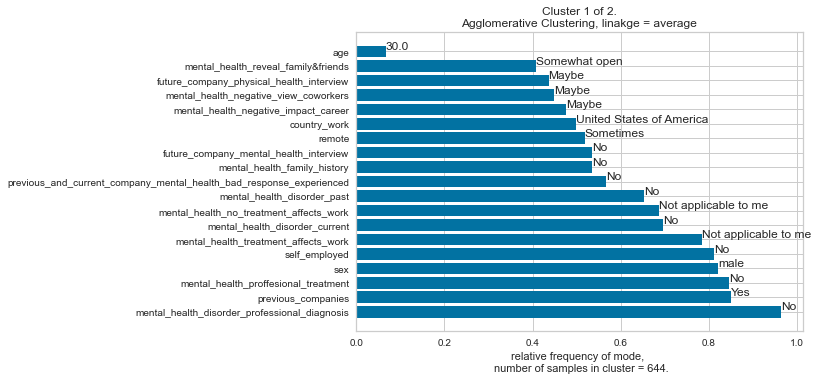

<Figure size 40000x4000 with 0 Axes>

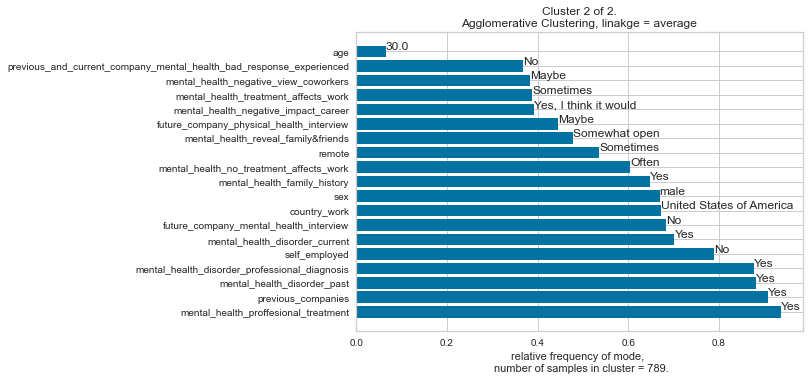

<Figure size 40000x4000 with 0 Axes>

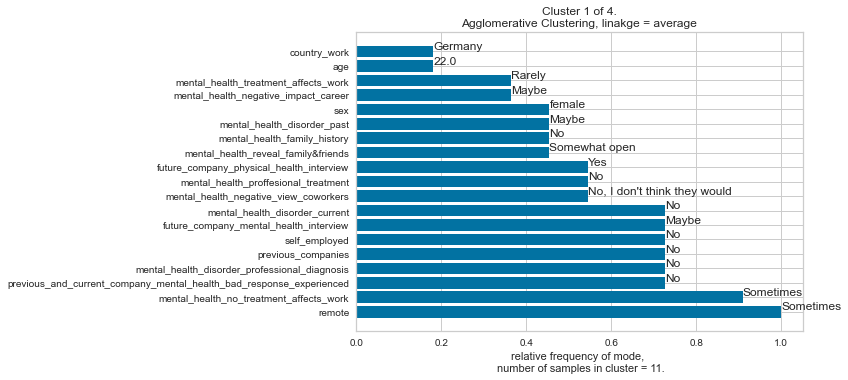

<Figure size 40000x4000 with 0 Axes>

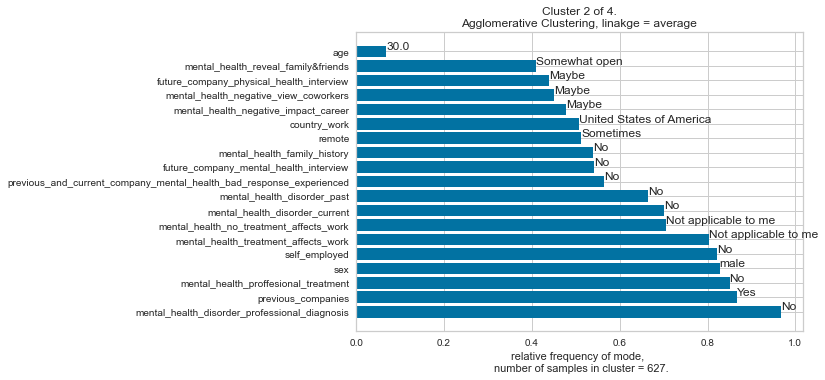

<Figure size 40000x4000 with 0 Axes>

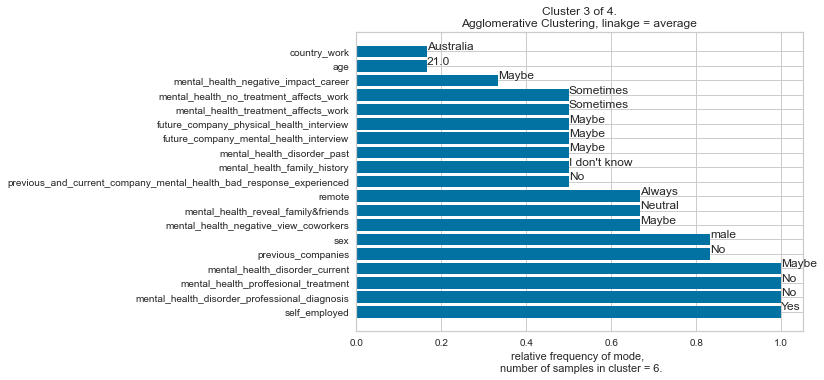

<Figure size 40000x4000 with 0 Axes>

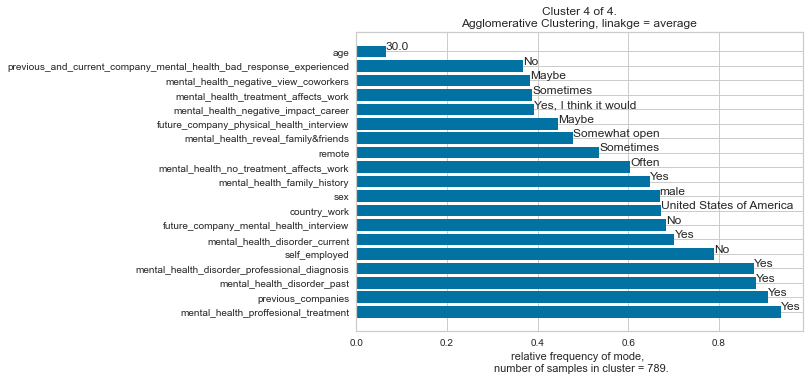

<Figure size 40000x4000 with 0 Axes>

In [114]:
# hence the dendogram implied two or four clusters I am going with those options. 
# option 1 and 4 of the df_silhouette_score_hierarchical_eda dictionary contain those clusters combined with the optimal 
# linkage for the highest silhouete score.
df_x_label_text = df_silhouette_score_hierarchical_eda[(df_silhouette_score_hierarchical_eda['option'] == 1) | (df_silhouette_score_hierarchical_eda['option'] == 4)]
print(df_silhouette_score_hierarchical_eda)


for option in df_x_label_text["option"]:
    for cluster in df_visualisation_hierachical[option]:
        df_visualisation_hierachical[option][cluster]
        
        y_pos = np.arange(len(df_visualisation_hierachical[option][cluster]["column"]))

        plt.barh(y_pos, df_visualisation_hierachical[option][cluster]["relative frequency"], alpha=1)
        plt.yticks(y_pos, df_visualisation_hierachical[option][cluster]["column"])
        plt.xlabel(f"relative frequency of mode, \n number of samples in cluster = \
{len(dataframes_dict_hierarchical_clustered[option][cluster])}.")
        plt.title(f"Cluster {cluster+1} of {df_x_label_text.loc[df_x_label_text['option'] == option, 'no. of cluster'].iloc[0]}.\n\
Agglomerative Clustering, linakge = {df_x_label_text.loc[df_x_label_text['option'] == option, 'method'].iloc[0]}")
        for y, mode in zip(range(len(df_visualisation_hierachical[option][cluster]["column"])), df_visualisation_hierachical[option][cluster]["mode"]):
            plt.text(df_visualisation_hierachical[option][cluster]["relative frequency"][y], y, mode, va="bottom")

#plt.tight_layout()
        plt.figure(dpi=400, figsize=(100, 10))  
        plt.show()


In [62]:
# df_silhouette_score_dropped.sort_values(by="score_loss", inplace=True)
# df_silhouette_score_dropped.reset_index(inplace=True)
# df_silhouette_score_dropped.drop(columns="index", axis = 1, inplace = True)
# df_silhouette_score_dropped

Doing a PCA on the OHE data, to see if it yields better results than the gower approach.

In [136]:
# scaling the only numerical feature wihtin the data.
list_of_ohe_df = ["df_ohe_w/o_bow_features", "df_ohe_with_bow_features"]

for x in list_of_ohe_df:
    df_ohe_pca_dict[x]["age"] = StandardScaler().fit_transform(dataframes_dict[x]["age"].array.reshape(-1, 1))



Doing the PCA

In [169]:
# Loop Function to identify number of principal components that explain at least 85% of the variance
pca_df = {}
for x in df_ohe_pca_dict:
    print(x)
    


    for comp in range(3, df_ohe_pca_dict[x].shape[1]):
        pca = PCA(n_components= comp, random_state=42)
        pca.fit(df_ohe_pca_dict[x])
        comp_check = pca.explained_variance_ratio_
        final_comp = comp
        if comp_check.sum() > 0.85:
            break
        
    Final_PCA = PCA(n_components= final_comp,random_state=42)
    Final_PCA.fit(df_ohe_pca_dict[x])
    pca_df[x]=Final_PCA.transform(df_ohe_pca_dict[x])
    num_comps = comp_check.shape[0]
    print(f"Using {final_comp} components, we can explain {comp_check.sum()}% of the variability in the original data of df {x}")


# footnote: took this line of code from 
# https://towardsdatascience.com/one-hot-encoding-standardization-pca-data-preparation-steps-for-segmentation-in-python-24d07671cf0b


print("That is not a great result. Basically the OHE created more features even after PCA, than the original dataset had " \
"even after dropping the country_live column, which had one of the highest cardinalities.")

df_ohe_w/o_bow_features
Using 26 components, we can explain 0.8611219785060845% of the variability in the original data of df df_ohe_w/o_bow_features
df_ohe_with_bow_features
Using 33 components, we can explain 0.8517662262543125% of the variability in the original data of df df_ohe_with_bow_features
That is not a great result. Basically the OHE created more features even after PCA, than the original dataset had even after dropping the country_live column, which had one of the highest cardinalities.


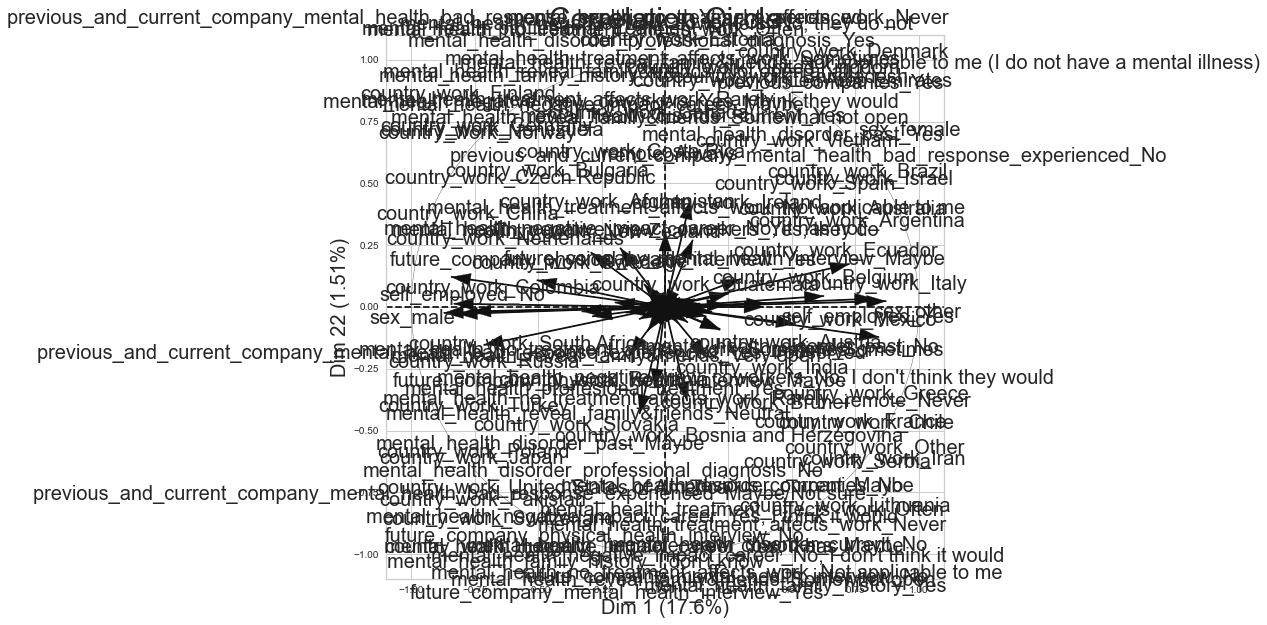

In [65]:
# calculation a correlation matrix.

feature_names = df_ohe_pca.columns.to_list()

# calculate the correlation matrix and
# create a correlation graph
fig, cor_mat = plot_pca_correlation_graph(df_ohe_pca, \
    feature_names, dimensions=(1, 22), \
    figure_axis_size=10)
plt.show()



In [199]:
df_ohe_pca_performed = pd.DataFrame(pca_df["df_ohe_w/o_bow_features"])
# df_ohe_pca_performed.drop(columns="cluster", inplace=True)

# DBSCAN_cluster = DBSCAN(eps=3, min_samples=20).fit(df_ohe_pca_performed) 
# df_ohe_pca_performed["cluster"]=DBSCAN_cluster.labels_
# df_ohe_pca_performed["cluster"].nunique()




Again, finding the best eps and min_sample scores.

In [216]:
eps_list = []
for i in np.linspace(1.0, 10.0, num=20):
    eps_list.append(i.round(2))


In [221]:
min_sampe_list = [x for x in range(2, 80 , 2)]

In [223]:
eps_list = []
for i in np.linspace(1.0, 10.0, num=20):
    eps_list.append(i.round(2))

min_sampe_list = [x for x in range(2, 80 , 2)]

data_all = []
for eps_value in eps_list:
        data1 = []
        data2 = []
        for min_sample in min_sampe_list:
            dbscan_cluster = DBSCAN(eps=eps_value, 
                            min_samples=min_sample, 
                            metric='euclidean')

            dbscan_cluster.fit(df_ohe_pca_performed)
    
            df_ohe_pca_performed["cluster"] = dbscan_cluster.labels_
            no_of_clusters = df_ohe_pca_performed["cluster"].nunique()
            
            data1.append(eps_value)
            data1.append(min_sample)
            score = np.nan
            try:
                score = metrics.silhouette_score(df_ohe_pca_performed, dbscan_cluster.labels_)
            except: ValueError

            
            data1.append(no_of_clusters)
            data1.append(score)
                
            
            data2 = [data1]
            data_all.extend(data2)
            data1 = []
            date2 = []  

df_silhouette_score_pca = pd.DataFrame(data_all, columns=['eps_value', 'min_sample', '# of clusters', 'score']) 
df_silhouette_score_pca  = df_silhouette_score_pca[df_silhouette_score_pca['score'].notna()]
df_silhouette_score_pca.loc[df_silhouette_score_pca['score'].idxmax()]



c:\Users\Max_G\anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Max_G\anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Max_G\anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Max_G\anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Max_G\anaconda3\lib

In [224]:
df_silhouette_score_pca.loc[df_silhouette_score_pca['score'].idxmax()]


eps_value         3.840000
min_sample       14.000000
# of clusters     2.000000
score             0.318279
Name: 240, dtype: float64

In [ ]:
df_silhouette_score_pca.loc[df_silhouette_score['score'].idxmax()]


In [ ]:
eps_list = []
for i in np.linspace(0.1, 0.3, num=29):
    eps_list.append(i.round(2))

min_sampe_list = [x for x in range(2, 11 , 1)]

data_all = []

for df_name in dataframes_dict:
    for eps_value in eps_list:
        data1 = []
        data2 = []
        for min_sample in min_sampe_list:
            dbscan_cluster = DBSCAN(eps=eps_value, 
                            min_samples=min_sample, 
                            metric="precomputed")

            dbscan_cluster.fit(gower_matrix_dict[df_name])
    
            dataframes_dict[df_name]["cluster"] = dbscan_cluster.labels_
            no_of_clusters = dataframes_dict[df_name]["cluster"].nunique()

            data1.append(df_name)
            data1.append(eps_value)
            data1.append(min_sample)
            score = np.nan
            try:
                score = metrics.silhouette_score(gower_matrix_dict[df_name], dbscan_cluster.labels_)
            except: ValueError
            data1.append(no_of_clusters)
            data1.append(score)
            
            
            data2 = [data1]
            data_all.extend(data2)
            data1 = []
            date2 = []  

df_silhouette_score = pd.DataFrame(data_all, columns=["df_name", 'eps_value', 'min_sample', '# of clusters', 'score']) 

Applying the optimal values to the clustering.

In [ ]:
dbscan_cluster = DBSCAN(eps=df_silhouette_score_pca.loc[df_silhouette_score['score'].idxmax()][0], 
                            min_samples=int(df_silhouette_score_pca.loc[df_silhouette_score['score'].idxmax()][1]), 
                            metric='euclidean')

dbscan_cluster.fit(df_ohe_pca_perforded)
df_ohe_pca_perforded["cluster"] = dbscan_cluster.labels_



In [ ]:
sample_cluster_0 = int(len(df_ohe_pca_perforded.loc[df_ohe_pca_perforded["cluster"]==0]))
sample_cluster_1 = int(len(df_ohe_pca_perforded.loc[df_ohe_pca_perforded["cluster"]==1]))
sample_cluster_n_1 = int(len(df_ohe_pca_perforded.loc[df_ohe_pca_perforded["cluster"]==-1]))

print("The number of samples in cluster 0 is, ", sample_cluster_0)
print("The number of samples in cluster 1 is, ", sample_cluster_1)
print("The number of samples in cluster -1 is, ", sample_cluster_n_1)

if  300 < sample_cluster_n_1 or sample_cluster_0 < 300 or sample_cluster_1 < 300: 
    print("This is an unaceptable high amount of not clustered data. This approach has yielded bad results." \
    "Therefore no EDA will be conducted. Please see DBSCAN with Gower-Distance for the EDA.") 